Setup

In [ ]:
!pip -q install scikit-learn pyod imbalanced-learn shap gradio==4.44.0 joblib pandas numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.66 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
google-genai 1.46.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
google-adk 1.17.0 requires websock

Imports & Config

In [ ]:
import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyod.models.iforest import IForest as PyODIForest
import joblib

DATA_PATH = "financial_anomaly_data.csv"
TS_COL = "Timestamp"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load raw data

In [ ]:
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH, on_bad_lines='skip')

print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Raw shape: (232653, 7)
Columns: ['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


Feature engineering

In [ ]:
import numpy as np
import pandas as pd

def freq_encode(series: pd.Series) -> pd.Series:
    freq = series.value_counts(dropna=False)
    return series.map(freq).astype(float)

def build_features(df_raw: pd.DataFrame, ts_col: str) -> pd.DataFrame:
    df = df_raw.copy()

    # 1) Parse and sort by time
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    missing_ts = df[ts_col].isna().mean()
    if missing_ts > 0.05:
        print(f"Warning: {missing_ts:.1%} timestamps could not be parsed.")
    df = df.sort_values(ts_col).reset_index(drop=True)

    # 2) Basic time features
    df["hour"]  = df[ts_col].dt.hour
    df["dow"]   = df[ts_col].dt.dayofweek
    df["dom"]   = df[ts_col].dt.day
    df["month"] = df[ts_col].dt.month

    # 3) Safe conversions
    if "Amount" in df.columns:
        df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")
    else:
        raise ValueError("Expected 'Amount' column not found.")
    df["Amount"] = df["Amount"].fillna(df["Amount"].median())
    df["amt_log"] = np.log1p(df["Amount"])

    # 4) Frequency encodings for common categoricals
    for col in ["Merchant", "TransactionType", "Location", "AccountID"]:
        if col in df.columns:
            df[f"{col}_freq"] = freq_encode(df[col].astype("category"))
        else:
            df[f"{col}_freq"] = 0.0  # if column missing in some rows/files

    # 5) Rolling behavior per AccountID (if available)
    if "AccountID" in df.columns:
        grp = df.groupby("AccountID", sort=False)
        df["acc_roll_mean"]   = grp["Amount"].transform(lambda s: s.rolling(20, min_periods=5).mean())
        df["acc_roll_std"]    = grp["Amount"].transform(lambda s: s.rolling(20, min_periods=5).std())
        df["acc_prev_amt"]    = grp["Amount"].shift(1)
        df["acc_txn_ct_w50"]  = grp["Amount"].transform(lambda s: s.rolling(50, min_periods=5).count())
        df["acc_amt_sum_w50"] = grp["Amount"].transform(lambda s: s.rolling(50, min_periods=5).sum())
    else:
        # Fallback if AccountID is missing
        df["acc_roll_mean"] = df["Amount"].rolling(20, min_periods=5).mean()
        df["acc_roll_std"]  = df["Amount"].rolling(20, min_periods=5).std()
        df["acc_prev_amt"]  = df["Amount"].shift(1)
        df["acc_txn_ct_w50"]= df["Amount"].rolling(50, min_periods=5).count()
        df["acc_amt_sum_w50"]=df["Amount"].rolling(50, min_periods=5).sum()

    # Differences / z-score within account
    df["acc_roll_std"] = df["acc_roll_std"].replace([np.inf, -np.inf], np.nan)
    df["acc_roll_std"] = df["acc_roll_std"].fillna(df["acc_roll_std"].median())
    df["acc_roll_mean"] = df["acc_roll_mean"].fillna(df["acc_roll_mean"].median())
    df["acc_prev_amt"] = df["acc_prev_amt"].fillna(df["acc_prev_amt"].median())

    df["acc_z"] = (df["Amount"] - df["acc_roll_mean"]) / (df["acc_roll_std"] + 1e-6)
    df["amt_diff_prev"] = df["Amount"] - df["acc_prev_amt"]

    # Keep numeric features only; drop timestamp from feature matrix
    num_df = df.select_dtypes(include=[np.number]).copy()
    for c in num_df.columns:
        col = num_df[c].replace([np.inf, -np.inf], np.nan)
        num_df[c] = col.fillna(col.median())

    features = num_df  # already numeric
    df_out = df[[ts_col]].join(features)
    return df_out

df_fe = build_features(df, TS_COL)
print("Engineered shape:", df_fe.shape)
display(df_fe.head())

Engineered shape: (232653, 18)


,Timestamp,Amount,hour,dow,dom,month,amt_log,Merchant_freq,TransactionType_freq,Location_freq,AccountID_freq,acc_roll_mean,acc_roll_std,acc_prev_amt,acc_txn_ct_w50,acc_amt_sum_w50,acc_z,amt_diff_prev
0,2023-01-01 08:00:00,95071.92,8.0,6.0,1.0,1.0,11.462399,23008.0,77305.0,46321.0,15448.0,50074.57,28789.750701,50216.71,50.0,2503339.66,1.562964,44855.21
1,2023-01-01 08:01:00,15607.89,8.0,6.0,1.0,1.0,9.655596,23008.0,77305.0,46328.0,15394.0,50074.57,28789.750701,50216.71,50.0,2503339.66,-1.197186,-34608.82
2,2023-01-01 08:02:00,65092.34,8.0,6.0,1.0,1.0,11.083578,23058.0,76985.0,46328.0,15473.0,50074.57,28789.750701,50216.71,50.0,2503339.66,0.521636,14875.63
3,2023-01-01 08:03:00,87.87,8.0,6.0,1.0,1.0,4.487175,23058.0,77305.0,46328.0,15337.0,50074.57,28789.750701,50216.71,50.0,2503339.66,-1.736267,-50128.84
4,2023-01-01 08:04:00,716.56,8.0,6.0,1.0,1.0,6.575857,23264.0,77305.0,46399.0,15337.0,50074.57,28789.750701,87.87,50.0,2503339.66,-1.714430,628.69


Define feature matrix X & time index

In [ ]:
ts = pd.to_datetime(df_fe[TS_COL], errors="coerce")
X = df_fe.drop(columns=[TS_COL])

print("Final feature count:", X.shape[1])
print("Any NaN left?", X.isna().any().any())

Final feature count: 17
Any NaN left? False


Time-aware train/test split

In [ ]:
order = np.argsort(ts.values)
cut = int(0.8 * len(order))
tr_idx, te_idx = order[:cut], order[cut:]

X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

Train size: (186122, 17) | Test size: (46531, 17)


Scale features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Scaled shapes:", X_train_s.shape, X_test_s.shape)

Scaled shapes: (186122, 17) (46531, 17)


Train Unsupervised Anomaly Detector (Isolation Forest via PyOD)

In [ ]:
from pyod.models.iforest import IForest as PyODIForest

# contamination ~ expected anomaly rate. Start with 1%.
CONTAMINATION = 0.01

iforest = PyODIForest(
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_estimators=300,
)
iforest.fit(X_train_s)
scores_test = iforest.decision_function(X_test_s)
print("Scores summary:", pd.Series(scores_test).describe().to_dict())

Scores summary: {'count': 46531.0, 'mean': -0.14037805968156028, 'std': 0.027024312478390607, 'min': -0.19563174351820906, '25%': -0.16036871463793576, '50%': -0.1442542398264111, '75%': -0.12460806211379669, 'max': 0.004516590967864054}


Choose operational threshold

{'policy': 'top-k by review rate', 'target_review_rate_pct': 1.0, 'actual_flagged_pct': np.float64(1.001), 'threshold': -0.06159877965955869}


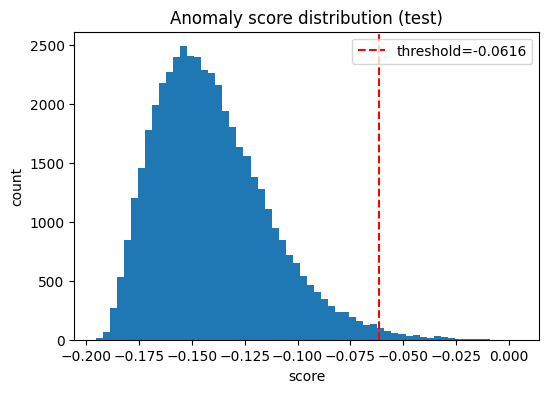

In [ ]:
def threshold_for_review_rate(scores: np.ndarray, review_rate: float) -> float:
    review_rate = np.clip(review_rate, 0.001, 0.5)  # keep sane
    q = 1.0 - review_rate
    return float(np.quantile(scores, q))

TARGET_REVIEW_RATE = 0.01  # review top 1% of most anomalous txns
threshold = threshold_for_review_rate(scores_test, TARGET_REVIEW_RATE)

# Flag test set
flags_test = (scores_test >= threshold).astype(int)
percent_flagged = 100.0 * flags_test.mean()
print({
    "policy": "top-k by review rate",
    "target_review_rate_pct": TARGET_REVIEW_RATE * 100.0,
    "actual_flagged_pct": round(percent_flagged, 3),
    "threshold": threshold
})

# Quick plot to visualize score distribution and threshold
plt.figure(figsize=(6,4))
plt.hist(scores_test, bins=60)
plt.axvline(threshold, color="red", linestyle="--", label=f"threshold={threshold:.4f}")
plt.title("Anomaly score distribution (test)")
plt.xlabel("score"); plt.ylabel("count"); plt.legend(); plt.show()

Inspect top anomalies (test split)

In [ ]:
# Build a top anomalies table with original context for quick review
test_rows = df.iloc[te_idx].reset_index(drop=True)
topk_idx = np.argsort(scores_test)[::-1][:25]

top_anomalies = test_rows.iloc[topk_idx].copy()
top_anomalies["anomaly_score"] = scores_test[topk_idx]
display(top_anomalies.head(10))

top_anomalies.to_csv("top_anomalies_test.csv", index=False)
print("Saved: top_anomalies_test.csv")

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,anomaly_score
10140,28-02-2023 23:31,TXN978,ACC9,75724.63,MerchantE,Transfer,San Francisco,0.004517
22559,11-04-2023 13:32,TXN1,ACC4,70989.90,MerchantI,Withdrawal,London,0.000096
19150,01-04-2023 08:10,TXN585,ACC14,82959.55,MerchantA,Withdrawal,London,-0.007234
36128,20-03-2023 11:53,TXN219,ACC9,13874.31,MerchantF,Purchase,San Francisco,-0.009178
23786,10-04-2023 20:45,TXN390,ACC10,9667.98,MerchantJ,Withdrawal,San Francisco,-0.009256
7255,26-02-2023 20:36,TXN67,ACC11,48308.26,MerchantC,Purchase,New York,-0.009658
12781,05-04-2023 04:00,TXN1424,ACC5,35887.74,MerchantD,Purchase,San Francisco,-0.010914
46530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011023
8982,01-03-2023 17:35,TXN496,ACC9,293.61,MerchantB,Purchase,New York,-0.011623
23159,10-04-2023 12:07,TXN1494,ACC2,14097.12,MerchantH,Transfer,Tokyo,-0.012192


Saved: top_anomalies_test.csv


In [ ]:
os.makedirs("artifacts", exist_ok=True)

# Save scaler + model
joblib.dump(scaler, "artifacts/scaler.pkl")
joblib.dump(iforest, "artifacts/iforest.pkl")
joblib.dump(iforest, "artifacts/model.pkl")  # the app loads 'model.pkl'

metadata = {
    "best_model": "iforest",
    "threshold": float(threshold),
    "features": X.columns.tolist(),
    "policy": {
        "type": "top_k_review_rate",
        "target_review_rate": float(0.01)  # matches TARGET_REVIEW_RATE above
    }
}
with open("artifacts/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Artifacts saved:", os.listdir("artifacts"))

Artifacts saved: ['scaler.pkl', 'model.pkl', 'metadata.json', 'iforest.pkl']
